In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import gc

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_roc(y_test, y_pred):
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import precision_score, recall_score
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    roc_auc = auc(fpr, tpr) # compute area under the curve

    plt.figure(figsize=[8,6])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([0,1])
    ax2.set_xlim([0,1])

In [3]:
#example of raw dataset

dataset = pd.read_csv('raw_dataset.csv', sep=';')
dataset.head()

,user_id,timestamp,channels,actions
0,111055000025177,2017-11-08 20:47:37,channel_3,view
1,111055000025177,2017-11-11 21:47:46,channel_3,view
2,111055000025177,2017-11-12 03:18:18,channel_3,view
3,111055000025177,2017-11-12 20:34:45,channel_3,view
4,111055000025177,2017-11-15 14:14:57,channel_3,view


In [4]:
def min_preperation(dataset):
    
    dataset.actions = dataset.actions.replace({'view':'impression'})
    dataset = dataset.sort_values(['user_id', 'timestamp']).reset_index(drop=True)
    dataset.timestamp = pd.to_datetime(dataset.timestamp)
    dataset['row_id'] = range(0, dataset.shape[0])

    #remove conversions except first ones
    first_conv = dataset[dataset.actions == 'conversion']
    first_conv = first_conv.drop_duplicates(subset='user_id')[['user_id', 'row_id']]
    dataset = dataset.merge(first_conv, on='user_id', how='outer')
    idx = dataset[dataset.row_id_y.isnull() == True].index
    dataset.loc[idx, 'row_id_y'] = dataset.loc[idx, 'row_id_x']
    dataset = dataset[dataset.row_id_y >= dataset.row_id_x]

    #remove touchless conversions

    touchless = pd.DataFrame(dataset.user_id.value_counts())
    idx = touchless[touchless.user_id == 1].index
    touchless = dataset[(dataset.user_id.isin(idx) == True) & (dataset.actions == 'conversion')]['user_id']
    dataset = dataset[dataset.user_id.isin(touchless) == False]
    
    return dataset[['user_id', 'timestamp', 'channels', 'actions']]

dataset = min_preperation(dataset)

num_impres = dataset[dataset.actions == 'impression'].shape[0]
num_clicks = dataset[dataset.actions == 'click'].shape[0]
num_convs = dataset[dataset.actions == 'conversion'].shape[0]

print('impressions:', num_impres)
print('clicks:', num_clicks)
print('conversions:', num_convs)
print(f'{round(100 * num_convs/num_impres,2)}%')

impressions: 876183
clicks: 2607
conversions: 2653
0.3%


In [5]:
#dataset after data preperation
prep_dataset = pd.read_csv('prepared_dataset.csv', sep=';')
prep_dataset.head()

,user_id,channel_1,channel_2,channel_3,channel_4,conversions,duration
0,111055000025177,0.0,0.0,1.0,0.0,0.0,0
1,111055000533474,3.0,0.0,1.0,2.0,0.0,18
2,111055000731634,0.0,0.0,0.0,2.0,0.0,11
3,111055000795837,0.0,0.0,0.0,2.0,0.0,0
4,111055000808885,0.0,0.0,0.0,2.0,0.0,10


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    prep_dataset[['channel_1','channel_2','channel_3','channel_4']],
    prep_dataset['conversions'], test_size=0.33, random_state=42)

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

bagged_logReg = BaggingClassifier(base_estimator = LogisticRegression(), 
                                  n_estimators=100, bootstrap_features=True, n_jobs = 10)

bagged_logReg.fit(X_train, y_train)

y_pred = bagged_logReg.predict_proba(X_test)
y_pred = [x[1] for x in y_pred]

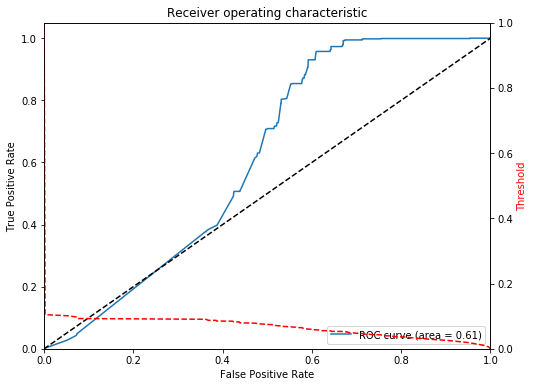

In [8]:
plot_roc(y_test, y_pred)

In [9]:
import xgboost

num_boost_round = 80
verbose_eval = num_boost_round // 5

scale_pos_weight = prep_dataset.conversions.value_counts()[0] / prep_dataset.conversions.value_counts()[1]
print('for unbalanced case use scale_pos_weight:', scale_pos_weight)
d_train = xgboost.DMatrix(X_train, y_train)
d_test = xgboost.DMatrix(X_test, y_test)

xgb_params = {
    "objective"        : "binary:logistic",
    "eval_metric"      : ["logloss", 'auc'],
    "eta"              : 0.1,    
    'scale_pos_weight' : scale_pos_weight,
    'max_delta_step'   : 5,#1,
    'reg_lambda'       : 3.8,
    'subsample'        : 0.95,
    "max_depth"        : 6, 
    'min_child_weight' : 5.0,
    "gamma"            : 0.70,
    "subsample"        : 0.76,
    "colsample_bytree" : 0.95,
    "alpha"            : 2e-05,
    "lambda"           : 10,
    'nthread'          : 20
}

watchlist= [(d_train, "train"), (d_test, "test")]

bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=num_boost_round, 
                    evals=watchlist, verbose_eval=verbose_eval)

for unbalanced case use scale_pos_weight: 13.738409347908028
[0]	train-logloss:0.670728	train-auc:0.743956	test-logloss:0.670107	test-auc:0.739755
[16]	train-logloss:0.530411	train-auc:0.82724	test-logloss:0.523376	test-auc:0.83138
[32]	train-logloss:0.494413	train-auc:0.847902	test-logloss:0.488027	test-auc:0.847693
[48]	train-logloss:0.480778	train-auc:0.850003	test-logloss:0.474568	test-auc:0.849518
[64]	train-logloss:0.473268	train-auc:0.851188	test-logloss:0.467907	test-auc:0.851147
[79]	train-logloss:0.471405	train-auc:0.851506	test-logloss:0.466667	test-auc:0.851927


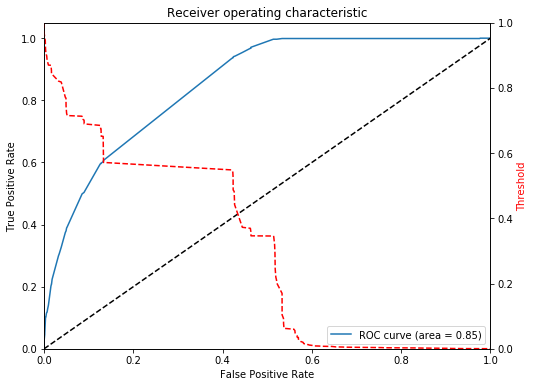

In [10]:
d_test = xgboost.DMatrix(X_test)
xgb_preds = bst.predict(d_test)

plot_roc(y_test, xgb_preds)

channel_1    0.052935
channel_2    0.025050
channel_3    0.109299
channel_4    0.260645
dtype: float64


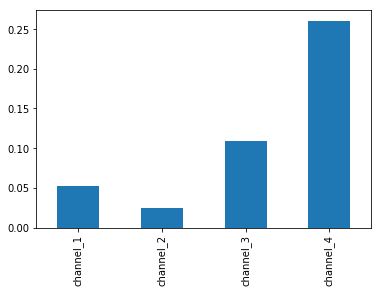

In [11]:
impacts = []

X_test['preds'] = xgb_preds
for channel in ['channel_1','channel_2','channel_3','channel_4']:
    impacts.append(X_test[X_test[channel] >= 1].preds.sum() / X_test.shape[0])

impacts = pd.Series(impacts, index=['channel_1','channel_2','channel_3','channel_4'])
impacts.plot(kind='bar', use_index=True);

print(impacts)

In [12]:
n_folds = 5
num_boost_round = 20
verbose_eval = num_boost_round // 5

cv = xgboost.cv(xgb_params, d_train, num_boost_round=num_boost_round, nfold=n_folds, 
                stratified=True, verbose_eval=verbose_eval)

[0]	train-auc:0.744021+0.00169374	train-logloss:0.670586+0.000452025	test-auc:0.742989+0.00765906	test-logloss:0.670624+0.000847259
[4]	train-auc:0.824539+0.00315898	train-logloss:0.603281+0.000703081	test-auc:0.824265+0.00475897	test-logloss:0.603501+0.00242339
[8]	train-auc:0.82192+0.00997627	train-logloss:0.568392+0.00300781	test-auc:0.819945+0.0120871	test-logloss:0.568062+0.00498471
[12]	train-auc:0.832501+0.00554026	train-logloss:0.540974+0.00472891	test-auc:0.830323+0.00891782	test-logloss:0.541122+0.00757071
[16]	train-auc:0.83353+0.00553707	train-logloss:0.523847+0.00375063	test-auc:0.831343+0.00952939	test-logloss:0.524032+0.00767778
[19]	train-auc:0.836387+0.00618954	train-logloss:0.514843+0.00472264	test-auc:0.834116+0.0107002	test-logloss:0.515087+0.00881796


In [13]:
##add offline tv ratings data

In [14]:
offline_data = pd.read_csv('offline_data.csv', sep=';')
offline_data.date = pd.to_datetime(offline_data.date)
offline_data['dayofyear'] = offline_data.date.dt.dayofyear

dataset['dayofyear'] = dataset.timestamp.dt.dayofyear
dataset = dataset.merge(offline_data[['grp', 'dayofyear']], on='dayofyear', how='outer').fillna(0)

tv = pd.DataFrame(dataset.groupby('user_id')['grp'].sum()).reset_index()
tv.columns = ['user_id', 'tv_ratings']

prep_dataset = prep_dataset.merge(tv, on='user_id')[['channel_1','channel_2','channel_3','channel_4' ,'conversions','tv_ratings']]

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    prep_dataset[['channel_1','channel_2','channel_3','channel_4', 'tv_ratings']],
    prep_dataset['conversions'], test_size=0.33, random_state=42)

In [16]:
num_boost_round = 150
verbose_eval = num_boost_round // 5

scale_pos_weight = prep_dataset.conversions.value_counts()[0] / prep_dataset.conversions.value_counts()[1]
print('for unbalanced case use scale_pos_weight:', scale_pos_weight)
d_train = xgboost.DMatrix(X_train, y_train)
d_test = xgboost.DMatrix(X_test, y_test)

xgb_params = {
    "objective"        : "binary:logistic",
    "eval_metric"      : ["logloss", 'auc'],
    "eta"              : 0.1,    
    'scale_pos_weight' : scale_pos_weight,
    'max_delta_step'   : 5,#1,
    'reg_lambda'       : 3.8,
    'subsample'        : 0.95,
    "max_depth"        : 6, 
    'min_child_weight' : 5.0,
    "gamma"            : 0.70,
    "subsample"        : 0.76,
    "colsample_bytree" : 0.95,
    "alpha"            : 2e-05,
    "lambda"           : 10,
    'nthread'          : 20
}

watchlist= [(d_train, "train"), (d_test, "test")]

bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=num_boost_round, 
                    evals=watchlist, verbose_eval=verbose_eval)

for unbalanced case use scale_pos_weight: 13.738409347908028
[0]	train-logloss:0.664352	train-auc:0.790164	test-logloss:0.663357	test-auc:0.788242
[30]	train-logloss:0.482069	train-auc:0.858348	test-logloss:0.47615	test-auc:0.855942
[60]	train-logloss:0.451183	train-auc:0.874687	test-logloss:0.447966	test-auc:0.863567
[90]	train-logloss:0.427424	train-auc:0.890491	test-logloss:0.429799	test-auc:0.866519
[120]	train-logloss:0.414013	train-auc:0.899948	test-logloss:0.420554	test-auc:0.8667
[149]	train-logloss:0.402726	train-auc:0.907767	test-logloss:0.413759	test-auc:0.866063


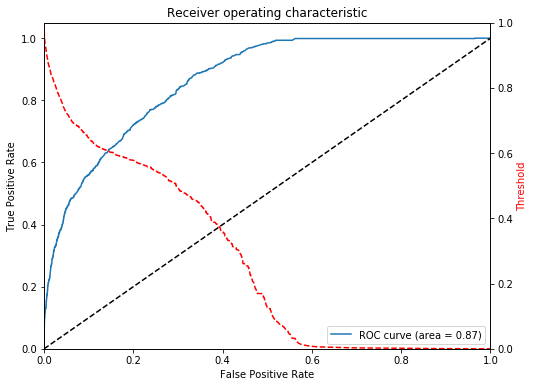

In [17]:
d_test = xgboost.DMatrix(X_test)
xgb_preds = bst.predict(d_test)

plot_roc(y_test, xgb_preds)

channel_1     0.046663
channel_2     0.022907
channel_3     0.096189
channel_4     0.241142
tv_ratings    0.286571
dtype: float64


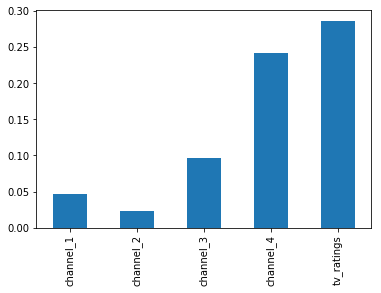

In [18]:
impacts = []

X_test['preds'] = xgb_preds
for channel in ['channel_1','channel_2','channel_3','channel_4', 'tv_ratings']:
    impacts.append(X_test[X_test[channel] >= 1].preds.sum() / X_test.shape[0])

impacts = pd.Series(impacts, index=['channel_1','channel_2','channel_3','channel_4', 'tv_ratings'])
impacts.plot(kind='bar', use_index=True);

print(impacts)

In [19]:
n_folds = 5
num_boost_round = 150
verbose_eval = num_boost_round // 5

cv = xgboost.cv(xgb_params, d_train, num_boost_round=num_boost_round, nfold=n_folds, 
                stratified=True, verbose_eval=verbose_eval)

[0]	train-auc:0.801152+0.0133697	train-logloss:0.662666+0.00203569	test-auc:0.796324+0.0121755	test-logloss:0.66274+0.00218079
[30]	train-auc:0.866151+0.00205913	train-logloss:0.474864+0.00233373	test-auc:0.857842+0.00963686	test-logloss:0.476708+0.005661
[60]	train-auc:0.880238+0.00118149	train-logloss:0.442621+0.0023466	test-auc:0.865612+0.00669302	test-logloss:0.447216+0.00586449
[90]	train-auc:0.89564+0.0015361	train-logloss:0.4215+0.00287739	test-auc:0.86604+0.00595914	test-logloss:0.43046+0.00359272
[120]	train-auc:0.905006+0.00122129	train-logloss:0.405834+0.00320878	test-auc:0.865986+0.00562107	test-logloss:0.418931+0.00408822
[149]	train-auc:0.912177+0.0010006	train-logloss:0.393726+0.00191518	test-auc:0.866568+0.00540435	test-logloss:0.409891+0.00373705
